<IPython.core.display.Javascript object>


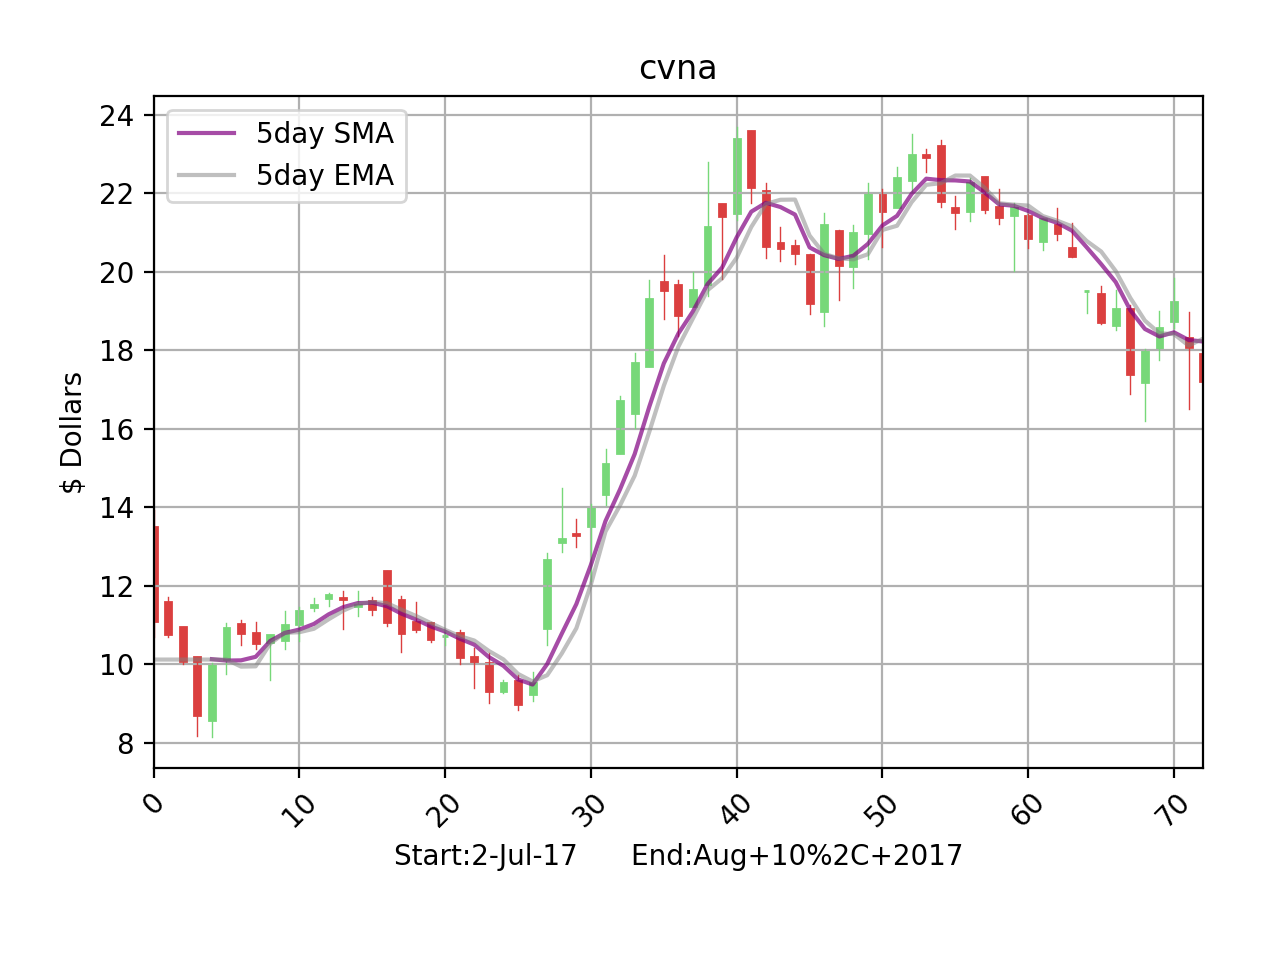

URL is: http://www.google.com/finance/historical?q=cvna&startdate=Jan+7%2C+2016&enddate=Aug+10%2C+2017&output=csv
['2017-07-02|cvna', 11.1, 10.77, 10.1, 8.72, 9.98, 10.92, 10.8, 10.55, 10.74, 11.0, 11.35, 11.52, 11.76, 11.66, 11.52, 11.4, 11.08, 10.81, 10.91, 10.65, 10.73, 10.18, 10.05, 9.33, 9.53, 9.0, 9.53, 12.66, 13.2, 13.3, 14.0, 15.11, 16.7, 17.68, 19.31, 19.54, 18.91, 19.53, 21.14, 21.43, 23.39, 22.17, 20.66, 20.6, 20.47, 19.21, 21.18, 20.18, 21.0, 21.99, 21.56, 22.4, 22.98, 22.93, 21.8, 21.53, 22.26, 21.6, 21.4, 21.62, 20.87, 21.35, 20.99, 20.41, 19.52, 18.71, 19.06, 17.41, 18.02, 18.57, 19.23, 18.09, 17.21]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:185: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=5,center=False).mean()


In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.finance import candlestick_ohlc

import numpy as np
import urllib
import datetime as dt
from datetime import datetime
import pandas as pd
import csv
import time

#url = "https://raw.github.com/datasets/gdp/master/data/gdp.csv"

#datareader = csv.reader(io.TextIOWrapper(webpage))

def ExpMovingAverage(values, window):
    weights = np.exp(np.linspace(-1., 0., window))
    weights /= weights.sum()
    a =  np.convolve(values, weights, mode='full')[:len(values)]
    a[:window] = a[window]
    return a

# convert "yyyymmdd" to float
def yyyymmdd2num(s):
    return mdates.date2num(dt.datetime(int(s[0:4]), int(s[4:6]), int(s[6:8])))


def graph_data(stock,start,end,numb_analysis_days,jump_day):
    fig = plt.figure()
    ax1 = plt.subplot2grid((1,1), (0,0))
    #ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)
    
    # fix jump day issues
    if jump_day == 'na':
        jump_day = 9999999
        jump_day_index = 9999999

    url= "http://www.google.com/finance/historical?q="+stock+"&startdate=Jan+7%2C+2016&enddate="+end+"&output=csv"
    #url= "http://www.google.com/finance/historical?q="+stock+"&startdate=Apr+17%2C+2017&enddate=Jul+30%2C+2017&output=csv"
    source_code = urllib.request.urlopen(url).read().decode()
    
    print('URL is: '+url)

    stock_data = []
    split_source = source_code.split('\n')
    for line in split_source:
        split_line = line.split()
        if 'Volume' not in line:
            stock_data.append(line)
    

    date_arr = []
    reader = csv.reader(stock_data)
    your_list = list(reader) 
    x = 0
    stopnow = 0
    
    #flip days so the chart runs the right way
    for line in stock_data:
        if line != '':
            date, openp, highp, lowp, closep, volume = line.split(',')
            
            date_object = datetime.strptime(date, '%d-%b-%y')
            #print(date_object.strftime('%Y-%m-%d'))
            
            date_arr.append(date_object.strftime('%Y-%m-%d'))
            x+=1
            
            if date == start:
                stopnow = 1
                break
        if stopnow == 1:
            break
    date_arr.reverse()
    
    
    #get rest of chart data and add day
    temp_ohlc = []
    x = 0
    stopnow = 0
    
    for line in stock_data:
        if line != '':
            date, openp, highp, lowp, closep, volume = line.split(',')
            
            if x == 0:
                straight_line_num = openp
            
            if openp == '-':
                openp = closep
            if highp == '-':
                highp = closep
            if lowp == '-':
                lowp = closep
            
            date_object = datetime.strptime(date, '%d-%b-%y')
            date_object = date_object.strftime('%Y%m%d')
            new_date = yyyymmdd2num(date_object)
            
            append_me = float(x), float(openp), float(highp), float(lowp), float(closep), float(volume)
            temp_ohlc.append(append_me)
            
            date_object = datetime.strptime(date, '%d-%b-%y')
            date_object = date_object.strftime('%Y%m%d')
            
            #get correct jump day for next step in reorder
            if date == jump_day:
                jump_day_index = x
                jump_day_closep = closep
            
            x+=1
            
            if date == start: # start of data
                stopnow = 1
                break
        if stopnow == 1:
            break
    
    
    #loop and reorder ohlc list
    x = len(temp_ohlc) - 1
    if x > numb_analysis_days:
        x = numb_analysis_days - 1
    y = 0
    ohlc = []
    loop=0
    
    while x >= y:
        
        date, openp, highp, lowp, closep, volume = temp_ohlc[x]
        append_me = float(loop), float(openp), float(highp), float(lowp), float(closep), float(volume)
        ohlc.append(append_me) 
        
        if loop == 0:
            date_object = datetime.strptime(start, '%d-%b-%y')
            date_object = date_object.strftime('%Y-%m-%d')
            close_value = [str(date_object)+'|'+stock]
        
        close_value.extend([float(closep)])
        
        #Put a dot on jump day!
        if date == jump_day_index:
            plt.plot([loop], [jump_day_closep], 'ro', color="green", label='Jump Close')
        
        x-=1
        loop+=1
  
    print(close_value)
        
    
    #### moving average
    x = 0
    y = len(ohlc)
    moving_avg = 5 # default is 7 on 60 day chart; 50 on large charts; 120 day is 11
    label_ma = str(moving_avg)+'day SMA'
    data_ma = pd.DataFrame(columns=('date', label_ma))
    label_close = 'Close'
    data_close = pd.DataFrame(columns=('date', label_close))
    ema = []
    
    while x < y:
        date, openp, highp, lowp, closep, volume = ohlc[x]        
        data_ma.loc[x] = [date, closep]
        data_close.loc[x] = [date, closep]
        ema.append(closep)
        x+=1
        
    ### ema
    ema_num = 5 # default is 7 on 60 day graph; 50 on large charts; 120 day is 11
    ema = ExpMovingAverage(ema, ema_num) ## WHERE EMA ACTUALLY TAKES PLACE; 
    label_ema = str(ema_num)+'day EMA'
    data_ema = pd.DataFrame(columns=('date', label_ema))
    x = 0
    for line in ema:
        data_ema.loc[x] = [x, line]
        x+=1
    
    #print(data_ema)
    
    data_ma = data_ma.set_index('date') # set index to date  
    data_ma = data_ma.reset_index(drop=True)
    data_ma = pd.rolling_mean(data_ma, moving_avg)
    
    data_close = data_close.set_index('date') # set index to date  
    data_close = data_close.reset_index(drop=True)
    
    data_ema = data_ema.set_index('date') # set index to date  
    data_ema = data_ema.reset_index(drop=True)
    
    #plot for candlestick
    candlestick_ohlc(ax1, ohlc, width=0.4, colorup='#77d879', colordown='#db3f3f')
    
    #----- PLOT EVERYTHING ELSE
    data_ma.plot(ax=ax1, alpha=0.7, color="purple", label=label_ma ) #moving average
    data_ema.plot(ax=ax1, alpha=0.5, color="gray", label=label_ema ) #ema
    #data_close.plot(ax=ax1, alpha=0.5, color="black", label=label_close ) #close price
    
    

    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)

    #ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # only use if you want to see dates
    #ax1.xaxis.set_major_locator(mticker.MaxNLocator(10)) # only use if you want to see dates
    ax1.grid(True)

    
    
    plt.xlabel('Start:'+start+'      End:'+end)
    plt.ylabel('$ Dollars')
    plt.title(stock)
    plt.legend()
    plt.subplots_adjust(left=0.12, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
    plt.show()
    
    
    
#graph_data('SYX','Jan+7%2C+2016','Dec+23%2C+2016')  
graph_data('cvna','2-Jul-17','Aug+10%2C+2017', 9999, 'na') #look @ 90 & 220; use na AT END for no jump day OR 3-Apr-17; keep at 60 for normal analysis
#graph_data('MIXT','25-May-17','Aug+2%2C+2017')
#graph_data('SYX')   